In [1]:
import numpy as np
import pandas as pd

In [2]:
# load and preprocess data
#import os
#os.listdir()

__DATA_DIR__ = "./drive/MyDrive/data-playground/sample_data_final.csv"

df = pd.read_csv(__DATA_DIR__,header = "infer")

df = df.drop(["user_id",
              "orders_outlier_ind",
              "room_nights_outlier_ind",
              "booking_gbv_outlier_ind",
              ],axis=1).reset_index(drop = True)

#df.head()

### Util: Detect group label bias on covariates

In [ ]:
def checkAdversarialLabel(A_group,
                    B_group,
                    covariates,
                    sample_frac = 1.0,
                    thr_max = 0.51,
                    thr_min = 0.49,
                    verbose = False
                    ):
  """
  Check if the group variants were stratified correctly using adverserial strategy

  Parameters:
  * A_group: Group A
  * B_group: Group B
  * covariates: List of covariates
  * sample_frac: Sample of fraction % for faster validation (default 1)
  * thr_max: Max threshold for ROC (default 0.51)
  * thr_min: Min threshold for ROC (default 0.49)
  * verbose: if True then print all step status

  Returns: True / False
  """ 
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import cross_val_predict
  from sklearn.metrics import roc_auc_score

  if verbose == True:
    print("Adverserial validation started...")
  if len(covariates) < 1:
    return False
  
  A_deepcopy = A_group.copy(deep = True)
  B_deepcopy = B_group.copy(deep = True)

  # if sample fraction is specified, extract the subsets randomly
  if (sample_frac < 1.0) and (sample_frac > 0.0):
    if verbose == True:
      print("Sampling {} of both datasets".format(sample_frac))

    A_deepcopy = A_deepcopy.sample(frac = sample_frac)
    B_deepcopy = B_deepcopy.sample(frac = sample_frac)
    
  # Prepare a dataset by combining A & B and put labels of the groups - 2 classes
  if verbose == True:
    print("Combine A & B groups and create group label for each")
  X = A_deepcopy.append(B_deepcopy) 
  y = [0]*len(A_deepcopy) + [1]*len(B_deepcopy) # put a pseudolabel

  # convert all categorical variables to binary 
  X = pd.get_dummies(X,columns = covariates)

  if verbose == True:
    print("Run a classifier to distinguish between the 2 datasets")
  model = RandomForestClassifier() # use RandomForest here but could be any classifier
  
  # do cross-val and output prediction of pseudo-label
  cv_preds = cross_val_predict(model, 
                               X, 
                               y, 
                               cv=2, 
                               n_jobs = None,
                               method = "predict_proba",
                               verbose = verbose)
  
  roc_score = roc_auc_score(y_true = y, y_score = cv_preds[:,1])
  if verbose == True:
    print ("ROC Score = {}".format(roc_score))
    print ("Adverserial validation finished.")

  return thr_min <= roc_score <= thr_max

In [ ]:
# create a test case
train = df[df["experiment_variant_code"]== "CONTROL"].drop("experiment_variant_code",axis = 1)
test = df[df["experiment_variant_code"] == "VARIANT"].drop("experiment_variant_code",axis = 1)
features = ["new_return_visitor","platform_type","posa_super_region","marketing_channel"]

print(checkAdversarialLabel(train,test,features,sample_frac = 0.1,verbose = True))



Adverserial validation started...
Sampling 0.1 of both datasets
Combine A & B groups and create group label for each
Run a classifier to distinguish between the 2 datasets


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ROC Score = 0.5026046946550645
Adverserial validation finished.
True


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.8s finished


### Utils: Perform chisqr tests on covariates

In [ ]:
def checkCovBalance(A_group,
               B_group,
               covariates,
               alpha = 0.05,
               verbose = False
              ):
  """
  Check if the group variants are balanced based on chi square tests

  Parameters:
  * A_group: Group A
  * B_group: Group B
  * covariates: List of covariates
  * alpha: Critical value (default 5%)
  * verbose: if True then print all step status

  Returns: List of unbalanced covariates (empty if not)
  """ 
 
  from scipy.stats import chi2_contingency

  if verbose == True:
    print("Covariate balancing check using Chisqr test...")

  if len(covariates) < 1:
    return False

  A_deepcopy = A_group.copy(deep = True)
  B_deepcopy = B_group.copy(deep = True)

  # label group
  A_deepcopy["group_"] = "A"
  B_deepcopy["group_"] = "B"

  # Prepare a dataset by combining A & B 
  if verbose == True:
    print("Combine A & B groups and create group label for each")
  AB_df = A_deepcopy.append(B_deepcopy) 

  output_list = []

  for cov in covariates:
      pct = pd.crosstab(AB_df[cov],AB_df["group_"],normalize = "columns")
      _, p, _, _ = chi2_contingency(pct) 

      if verbose == True:
        print("Covariate {}:".format(cov))
        print(pct)
        print("p_val = {}".format(p))
        print()
      
      if p <= alpha:
        output_list.append(cov)
  
  return output_list  

In [ ]:
# create a test case
train = df[df["experiment_variant_code"]== "CONTROL"].drop("experiment_variant_code",axis = 1)
test = df[df["experiment_variant_code"] == "VARIANT"].drop("experiment_variant_code",axis = 1)
features = ["new_return_visitor","platform_type","posa_super_region","marketing_channel"]

print(checkCovBalance(train,test,features,verbose = False))

[]


In [26]:
def detectTailedOutlier(A_group,
                        B_group,
                        targets,
                        remove_outlier = False,
                        tail_quantile_level = 0.99,
                        verbose = False):
  
  """
  Detect outliers based on tailed quantile with option of outlier removal

  Parameters:
  * A_group: Group A
  * B_group: Group B
  * target: Target variables
  * remove_outlier: Option to remove outlier (default False)
  * tail_quantile_level: The quantile beyond which the outlier is determined
  * verbose: if True then print all step status

  Returns: 
  * List of outlier level corresponding to each target (dict type)
  * A_group outliers removed if remove_outlier = True
  * B_group outliers removed if remove_outlier = True
  """ 

  if verbose == True:
    print("Detect outliers by quantiles...")
  
  if len(targets) < 1:
    return None, A_group, B_group

  A_deepcopy = A_group.copy(deep = True)
  B_deepcopy = B_group.copy(deep = True)

  # label group
  A_deepcopy["group_"] = "A"
  B_deepcopy["group_"] = "B"

  AB_df = A_deepcopy.append(B_deepcopy) 

  sum_stats = AB_df[targets].describe([0.01, 0.05, 0.20, 0.50, 0.80, 0.95, 0.99])

  if verbose == True:
    print("Pre-removal of outliers:")
    print(sum_stats.T)
    print()

  outliers = {}

  for tg in targets:
    outliers[tg] = AB_df[tg].quantile(tail_quantile_level)
    if remove_outlier:
      AB_df = AB_df[AB_df[tg] <= outliers[tg]]
      A_deepcopy = A_deepcopy[A_deepcopy[tg] <= outliers[tg]]
      B_deepcopy = B_deepcopy[B_deepcopy[tg] <= outliers[tg]]

  if verbose == True:
    sum_stats = AB_df[targets].describe([0.01, 0.05, 0.20, 0.50, 0.80, 0.95, 0.99])
    print("Post_removal of outliers:")
    print(sum_stats.T)

  
  return outliers, A_deepcopy, B_deepcopy


In [8]:
# create a test case
train = df[df["experiment_variant_code"]== "CONTROL"].drop("experiment_variant_code",axis = 1)
test = df[df["experiment_variant_code"] == "VARIANT"].drop("experiment_variant_code",axis = 1)
features = ["new_return_visitor","platform_type","posa_super_region","marketing_channel"]
targets = ["orders","room_nights","booking_gbv"]
ls,train,test= detectTailedOutlier(train,
                                   test,
                                   targets,
                                   remove_outlier = True, 
                                   verbose = True)

Detect outliers by quantiles...
Pre-removal of outliers:
                 count       mean           std  min   1%   5%  20%  50%  80%  \
orders       1948770.0   0.169919      1.719938  0.0  0.0  0.0  0.0  0.0  0.0   
room_nights  1948770.0   0.386600      4.578911  0.0  0.0  0.0  0.0  0.0  0.0   
booking_gbv  1948770.0  62.053404  15230.745479  0.0  0.0  0.0  0.0  0.0  0.0   

                  95%        99%         max  
orders         1.0000     3.0000      1185.0  
room_nights    2.0000     8.0000      1569.0  
booking_gbv  180.7516  1099.0882  21245984.0  

Post_removal of outliers:
                 count       mean        std  min   1%   5%  20%  50%  80%  \
orders       1895927.0   0.070207   0.301279  0.0  0.0  0.0  0.0  0.0  0.0   
room_nights  1895927.0   0.106461   0.491195  0.0  0.0  0.0  0.0  0.0  0.0   
booking_gbv  1895927.0  10.486396  49.949332  0.0  0.0  0.0  0.0  0.0  0.0   

                   95%         99%     max  
orders        1.000000    1.000000    3.00  


### Utils: Test normality of a given group using Shapiro test

In [24]:
def checkNormality(group,
                  targets,
                  alpha = 0.05,
                  plot_dist = False,
                  verbose = False):
  
  """
  Check normality of the targett variables. If sample size is larger than 5000,
  use Shapiro-Wilk test (parametric). Otherwise, use Kolmogorov-Smirnoff test 
  (non-parametric)

  Parameters:
  * group: Input data
  * targets: Taget variables (list if multiple)
  * alpha: Critical value (default 0.05)
  * plot_dist: Plot histogram & density function if True (default False)
  * verbose:  print all step statuses if True (default False)

  Returns: 
  * Targets that are not normally distributed
  """ 
  if verbose == True:
    print("Test normality of the group...")

  from scipy import stats
  import matplotlib.pyplot as plt
  import seaborn as sns


  non_normal_targets = []
  N_sample = len(group) 
  if plot_dist:
    _,axes = plt.subplots(len(targets) // 3,
                          (len(targets)-1) % 3 + 1,
                          figsize = (15,4))

  for idx,tg in enumerate(targets):
    
    # if plot_dist set to True, plot the histogram & density function
    if plot_dist:
      sns.histplot(group[tg] , 
                   color="skyblue", 
                   kde = True, 
                   stat = "density",
                   label=tg,
                   ax = axes[idx])

    # if sample size is less than 5000, use Shapiro-Wilk test
    if N_sample < 5000:
      _, pval  = stats.shapiro(group[tg])
    # else use Kolmogorv-Smirnoff test against norm
    else:
      _, pval = stats.kstest(group[tg],stats.norm.cdf)

    if pval < alpha:
      non_normal_targets.append(tg)

    if verbose:
      print("Target {}: pval = {}".format(tg,pval))

  return non_normal_targets

Test normality of the group...
Covariate orders: pval = 0.0
Covariate room_nights: pval = 0.0
Covariate booking_gbv: pval = 0.0


['orders', 'room_nights', 'booking_gbv']

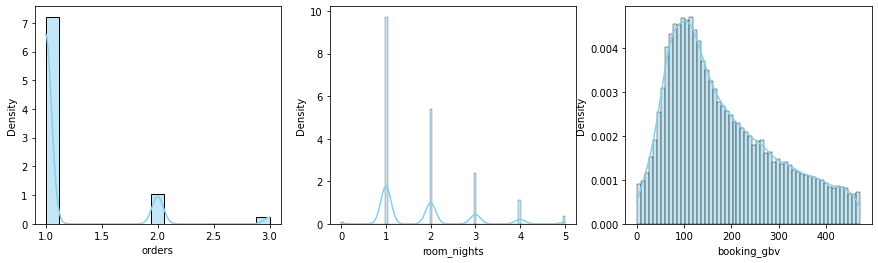

In [25]:
# create a few test cases
checkNormality(train[train["conv_ind"]>0],targets,plot_dist = True,verbose = True)

In [27]:
def checkVariance(A_group,
                  B_group,
                  targets,
                  alpha = 0.05,
                  plot_dist = False,
                  verbose = False):
  
  """
  Check homogeneity of variance for the 2 variants using Levene test

  Parameters:
  * A_group: Group A
  * B_group: Group B
  * targets: Taget variables (list if multiple)
  * alpha: Critical value (default 0.05)
  * plot_dist: Plot histogram & density function if True (default False)
  * verbose:  print all step statuses if True (default False)

  Returns: 
  * Targets that are not normally distributed
  """ 
  if verbose == True:
    print("Test homogeneity of variance of the group...")

  from scipy import stats
  import matplotlib.pyplot as plt
  import seaborn as sns

  non_homog_targets = []

  if plot_dist:
    _,axes = plt.subplots(len(targets),
                          2,
                          figsize = (10,4))

  for idx,tg in enumerate(targets):
    
    # if plot_dist set to True, plot the histogram & density function
    if plot_dist:
      sns.histplot(A_group[tg],color="skyblue",kde = True,stat = "density",label=tg,ax = axes[idx,0])
      sns.histplot(B_group[tg],color="red",kde = True,stat = "density",label=tg,ax = axes[idx,1])


    # if sample size is less than 5000, use Shapiro-Wilk test
    _, pval = stats.levene(A_group[tg],B_group[tg])

    if pval < alpha:
      non_homog_targets.append(tg)

    if verbose:
      print("Target {}: pval = {}".format(tg,pval))

  return non_homog_targets

In [ ]:
# create a few test cases
checkNormality(train[train["conv_ind"]>0],
               test[test["conv_ind"]>0],
               targets,
               plot_dist = True,
               verbose = True)

Test normality of the group...


KeyboardInterrupt: ignored